# Sampler statistics

When checking for convergence or when debugging a badly behaving
sampler, it is often helpful to take a closer look at what the
sampler is doing. For this purpose some samplers export
statistics for each generated sample.

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns

%matplotlib inline

print(f"Runing on PyMC3 v{pm.__version__}")

Runing on PyMC3 v3.11.0


In [2]:
warnings.filterwarnings("ignore", category=FutureWarning)

As a minimal example we sample from a standard normal distribution:

In [3]:
model = pm.Model()
with model:
    mu1 = pm.Normal("mu1", mu=0, sigma=1, shape=10)

In [4]:
with model:
    step = pm.NUTS()
    trace = pm.sample(2000, tune=1000, init=None, step=step, cores=2)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu1]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 15 seconds.


NUTS provides the following statistics:

In [5]:
trace.stat_names

{'depth',
 'diverging',
 'energy',
 'energy_error',
 'max_energy_error',
 'mean_tree_accept',
 'model_logp',
 'perf_counter_diff',
 'perf_counter_start',
 'process_time_diff',
 'step_size',
 'step_size_bar',
 'tree_size',
 'tune'}

- `mean_tree_accept`: The mean acceptance probability for the tree that generated this sample. The mean of these values across all samples but the burn-in should be approximately `target_accept` (the default for this is 0.8).
- `diverging`: Whether the trajectory for this sample diverged. If there are many diverging samples, this usually indicates that a region of the posterior has high curvature. Reparametrization can often help, but you can also try to increase `target_accept` to something like 0.9 or 0.95.
- `energy`: The energy at the point in phase-space where the sample was accepted. This can be used to identify posteriors with problematically long tails. See below for an example.
- `energy_error`: The difference in energy between the start and the end of the trajectory. For a perfect integrator this would always be zero.
- `max_energy_error`: The maximum difference in energy along the whole trajectory.
- `depth`: The depth of the tree that was used to generate this sample
- `tree_size`: The number of leafs of the sampling tree, when the sample was accepted. This is usually a bit less than $2 ^ \text{depth}$. If the tree size is large, the sampler is using a lot of leapfrog steps to find the next sample. This can for example happen if there are strong correlations in the posterior, if the posterior has long tails, if there are regions of high curvature ("funnels"), or if the variance estimates in the mass matrix are inaccurate. Reparametrisation of the model or estimating the posterior variances from past samples might help.
- `tune`: This is `True`, if step size adaptation was turned on when this sample was generated.
- `step_size`: The step size used for this sample.
- `step_size_bar`: The current best known step-size. After the tuning samples, the step size is set to this value. This should converge during tuning.
- `model_logp`: The model log-likelihood for this sample.

If the name of the statistic does not clash with the name of one of the variables, we can use indexing to get the values. The values for the chains will be concatenated.

We can see that the step sizes converged after the 1000 tuning samples for both chains to about the same value. The first 2000 values are from chain 1, the second 2000 from chain 2.

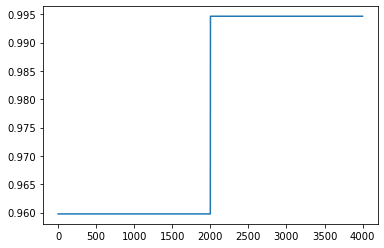

In [6]:
plt.plot(trace["step_size_bar"])

The `get_sampler_stats` method provides more control over which values should be returned, and it also works if the name of the statistic is the same as the name of one of the variables. We can use the `chains` option, to control values from which chain should be returned, or we can set `combine=False` to get the values for the individual chains:

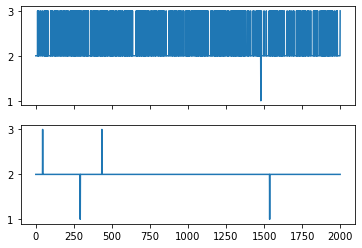

In [7]:
sizes1, sizes2 = trace.get_sampler_stats("depth", combine=False)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True)
ax1.plot(sizes1)
ax2.plot(sizes2)

plt.show()

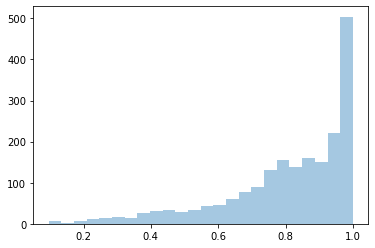

In [8]:
accept = trace.get_sampler_stats("mean_tree_accept", burn=1000)
sns.distplot(accept, kde=False)

plt.show()

In [9]:
accept.mean()

0.8085211584158867

Find the index of all diverging transitions:

In [10]:
trace["diverging"].nonzero()

(array([], dtype=int64),)

It is often useful to compare the overall distribution of the
energy levels with the change of energy between successive samples.
Ideally, they should be very similar:

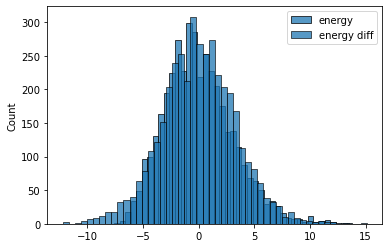

In [11]:
energy = trace["energy"]
energy_diff = np.diff(energy)
sns.histplot(energy - energy.mean(), label="energy")
sns.histplot(energy_diff, label="energy diff")
plt.legend()
plt.show()

If the overall distribution of energy levels has longer tails, the efficiency of the sampler will deteriorate quickly.

## Multiple samplers

If multiple samplers are used for the same model (e.g. for continuous and discrete variables), the exported values are merged or stacked along a new axis.

Note that for the `model_logp` sampler statistic, only the last column (i.e. `trace.get_sampler_stat('model_logp')[-1]`) will be the overall model logp.

In [12]:
model = pm.Model()
with model:
    mu1 = pm.Bernoulli("mu1", p=0.8)
    mu2 = pm.Normal("mu2", mu=0, sigma=1, shape=10)

In [13]:
with model:
    step1 = pm.BinaryMetropolis([mu1])
    step2 = pm.Metropolis([mu2])
    trace = pm.sample(10000, init=None, step=[step1, step2], cores=2, tune=1000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>BinaryMetropolis: [mu1]
>Metropolis: [mu2]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 12 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [14]:
trace.stat_names

{'accept', 'accepted', 'p_jump', 'scaling', 'tune'}

Both samplers export `accept`, so we get one acceptance probability for each sampler:

In [15]:
trace.get_sampler_stats("accept")

array([[1.00000000e+00, 4.60878937e-01],
       [1.00000000e+00, 2.80043811e-03],
       [4.00000000e+00, 3.07112391e+00],
       ...,
       [1.00000000e+00, 8.50108104e-03],
       [1.00000000e+00, 1.03066686e-01],
       [2.50000000e-01, 5.70415966e+01]])

In [16]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sat Feb 06 2021

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

pymc3     : 3.11.0
seaborn   : 0.11.1
pandas    : 1.2.1
numpy     : 1.20.0
matplotlib: None

Watermark: 2.1.0

